# Importint Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from itertools import product
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import lightgbm as lgb

# Loading Data

In [2]:
transactions = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops =  pd.read_csv('shops.csv')
categories = pd.read_csv('item_categories.csv')

test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
#Data Downcasting

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
all_df = [transactions, shops, items, categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.6% compressed
54.2% compressed
39.9% compressed
70.8% compressed


In [5]:
shops.shape

(60, 2)

In [6]:
items.shape

(22170, 3)

In [7]:
test.shape

(214200, 3)

In [8]:
test.shop_id.value_counts()    # 18 shops are not in test data

59    5100
16    5100
28    5100
26    5100
25    5100
24    5100
22    5100
21    5100
19    5100
18    5100
15    5100
58    5100
14    5100
12    5100
10    5100
7     5100
6     5100
5     5100
4     5100
3     5100
31    5100
34    5100
35    5100
36    5100
57    5100
56    5100
55    5100
53    5100
52    5100
50    5100
49    5100
48    5100
47    5100
46    5100
45    5100
44    5100
42    5100
41    5100
39    5100
38    5100
37    5100
2     5100
Name: shop_id, dtype: int64

In [9]:
test.item_id.count()  # and 

214200

In [10]:
test.groupby('item_id').shop_id.nunique()

item_id
30       42
31       42
32       42
33       42
38       42
         ..
22162    42
22163    42
22164    42
22166    42
22167    42
Name: shop_id, Length: 5100, dtype: int64

In [11]:
transactions.shop_id.nunique()  # all shops

60

In [12]:
transactions.item_id.nunique()   # from 22170 items

21807

In [13]:
transactions.shop_id.value_counts()

31    235636
25    186104
54    143480
28    142234
57    117428
42    109253
27    105366
6      82663
58     71441
56     69573
46     66321
50     65173
19     63911
15     59511
35     58445
21     58133
7      58076
47     56695
26     53910
18     53227
24     53032
53     52921
16     52734
30     50860
29     49225
38     46013
22     45434
51     44433
52     43502
59     42108
41     41967
37     39638
44     39530
43     39282
4      38242
5      38179
14     36979
45     35891
55     34769
12     34694
2      25991
3      25532
17     22950
48     21612
10     21397
13     17824
49     15849
39     13440
0       9857
32      7947
23      6963
34      5752
1       5678
33      5027
40      4257
9       3751
8       3412
20      1792
11       499
36       306
Name: shop_id, dtype: int64

In [14]:
test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int8)

In [16]:
transactions.date.min() 

'01.01.2013'

In [17]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [18]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1
1,2013-03-01,0,25,2552,899.000000,1
2,2013-05-01,0,25,2552,899.000000,-1
3,2013-06-01,0,25,2554,1709.050049,1
4,2013-01-15,0,25,2555,1099.000000,1
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1
2935845,2015-09-10,33,25,7460,299.000000,1
2935846,2015-10-14,33,25,7459,349.000000,1
2935847,2015-10-22,33,25,7440,299.000000,1


### Looking for some statistics

In [19]:
transactions.describe(include='all').T

<ipython-input-19-da36e4b5b30b>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  transactions.describe(include='all').T


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date,2935849,1034,2013-12-28,9434,2013-01-01,2015-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_block_num,2.93585e+06,NaN,NaT,NaN,NaT,NaT,14.5699,9.42299,0,7,14,23,33
shop_id,2.93585e+06,NaN,NaT,NaN,NaT,NaT,33.0017,16.227,0,22,31,47,59
item_id,2.93585e+06,NaN,NaT,NaN,NaT,NaT,10197.2,6324.3,0,4476,9343,15684,22169
item_price,2.93585e+06,NaN,NaT,NaN,NaT,NaT,890.623,1726.44,-1,249,399,999,307980
item_cnt_day,2.93585e+06,NaN,NaT,NaN,NaT,NaT,1.24264,2.61883,-22,1,1,1,2169


### Cheking for missing values

In [20]:
transactions.isnull().value_counts()

date   date_block_num  shop_id  item_id  item_price  item_cnt_day
False  False           False    False    False       False           2935849
dtype: int64

### Outiers

C:\Users\LAPTOP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_price'>

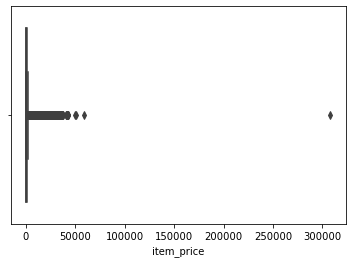

In [21]:
sns.boxplot(transactions.item_price)

C:\Users\LAPTOP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='item_cnt_day'>

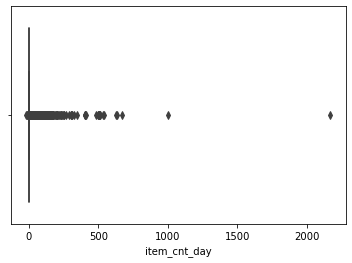

In [22]:
sns.boxplot(transactions.item_cnt_day)

### removing outliers

In [23]:
transactions = transactions[(transactions.item_price < 100000) & (transactions.item_price > 0)]
transactions = transactions[transactions.item_cnt_day < 1001]

# Preparing training data

### shops with the same names

In [24]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


### shop_ids are not found in the test data

In [25]:
test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int8)

In [26]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
transactions = transactions[transactions['shop_id'].isin(unique_test_shop_id)]

### Adding the city as a feature

In [27]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())

In [28]:
shops['city'].unique()

array(['!якутск', 'адыгея', 'балашиха', 'волжский', 'вологда', 'воронеж',
       'выездная', 'жуковский', 'интернет-магазин', 'казань', 'калуга',
       'коломна', 'красноярск', 'курск', 'москва', 'мытищи', 'н.новгород',
       'новосибирск', 'омск', 'ростовнадону', 'спб', 'самара', 'сергиев',
       'сургут', 'томск', 'тюмень', 'уфа', 'химки', 'цифровой', 'чехов',
       'якутск', 'ярославль'], dtype=object)

In [29]:
shops.loc[shops['city'] =='!якутск', 'city'] = 'якутск'

In [30]:
# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city_code'] = label_encoder.fit_transform(shops['city'])
shops['city_code'] = pd.factorize(shops['city'])[0]

In [31]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

In [32]:
shops.head()

,shop_id,city,city_code
0,0,якутск,0
1,1,якутск,0
2,2,адыгея,1
3,3,балашиха,2
4,4,волжский,3


### Adding the category as a feature

In [33]:

# Extract the first word of the item_categories_name into category
categories['category'] = categories['item_category_name'].apply(lambda x: x.split()[0])  

In [34]:
categories['category'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Чистые         2
Служебные      2
Элементы       1
PC             1
Доставка       1
Билеты         1
Name: category, dtype: int64

In [35]:
categories

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,PC
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары
...,...,...,...
79,Служебные,79,Служебные
80,Служебные - Билеты,80,Служебные
81,Чистые носители (шпиль),81,Чистые
82,Чистые носители (штучные),82,Чистые


In [36]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
categories['category'] = label_encoder.fit_transform(categories['category'])

In [37]:
# Remove item_category_name feature
#categories = categories.drop('item_category_name', axis=1)

In [38]:
categories

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
...,...,...,...
79,Служебные,79,12
80,Служебные - Билеты,80,12
81,Чистые носители (шпиль),81,13
82,Чистые носители (штучные),82,13


### Create the date the product was first sold as a feature

In [39]:
items['first_sale_date'] = transactions.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

In [40]:
items.head()

,item_name,item_id,item_category_id,first_sale_date
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,NaN
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,NaN
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,NaN
4,***КОРОБКА (СТЕКЛО) D,4,40,NaN


In [41]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

In [42]:
items

,item_name,item_id,item_category_id,first_sale_date
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,34.0
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,15.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,34.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,34.0
4,***КОРОБКА (СТЕКЛО) D,4,40,34.0
...,...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31,7.0
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54,9.0
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49,8.0
22168,Яйцо для Little Inu,22168,62,0.0


In [43]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1
1,2013-03-01,0,25,2552,899.000000,1
2,2013-05-01,0,25,2552,899.000000,-1
3,2013-06-01,0,25,2554,1709.050049,1
4,2013-01-15,0,25,2555,1099.000000,1
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1
2935845,2015-09-10,33,25,7460,299.000000,1
2935846,2015-10-14,33,25,7459,349.000000,1
2935847,2015-10-22,33,25,7440,299.000000,1


In [44]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [45]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1
1,2013-03-01,0,25,2552,899.000000,1
2,2013-05-01,0,25,2552,899.000000,-1
3,2013-06-01,0,25,2554,1709.050049,1
4,2013-01-15,0,25,2555,1099.000000,1
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1
2935845,2015-09-10,33,25,7460,299.000000,1
2935846,2015-10-14,33,25,7459,349.000000,1
2935847,2015-10-22,33,25,7440,299.000000,1


In [46]:
transactions['weekday'] = transactions['date'].dt.dayofweek

In [47]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday
0,2013-02-01,0,59,22154,999.000000,1,4
1,2013-03-01,0,25,2552,899.000000,1,4
2,2013-05-01,0,25,2552,899.000000,-1,2
3,2013-06-01,0,25,2554,1709.050049,1,5
4,2013-01-15,0,25,2555,1099.000000,1,1
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,5
2935845,2015-09-10,33,25,7460,299.000000,1,3
2935846,2015-10-14,33,25,7459,349.000000,1,2
2935847,2015-10-22,33,25,7440,299.000000,1,3


In [48]:
transactions['is_weekend'] = transactions['weekday'].apply(lambda x: 1 if x>4 else 0)

In [49]:
transactions['is_weekend'].value_counts()

0    1594552
1     818692
Name: is_weekend, dtype: int64

In [50]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,is_weekend
0,2013-02-01,0,59,22154,999.000000,1,4,0
1,2013-03-01,0,25,2552,899.000000,1,4,0
2,2013-05-01,0,25,2552,899.000000,-1,2,0
3,2013-06-01,0,25,2554,1709.050049,1,5,1
4,2013-01-15,0,25,2555,1099.000000,1,1,0
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,5,1
2935845,2015-09-10,33,25,7460,299.000000,1,3,0
2935846,2015-10-14,33,25,7459,349.000000,1,2,0
2935847,2015-10-22,33,25,7440,299.000000,1,3,0


In [51]:
data = transactions.loc[transactions['shop_id']==36]
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,is_weekend
2893625,2015-10-28,33,36,33,199.0,1,2,0
2893626,2015-10-27,33,36,806,249.0,1,1,0
2893752,2015-10-20,33,36,1293,349.0,1,1,0
2894147,2015-10-22,33,36,1332,499.0,1,3,0
2894148,2015-10-23,33,36,1583,3949.0,4,4,0
...,...,...,...,...,...,...,...,...
2894929,2015-10-30,33,36,20231,169.0,1,4,0
2894930,2015-10-18,33,36,20334,1949.0,1,6,1
2894931,2015-10-31,33,36,20339,1549.0,1,5,1
2894932,2015-10-31,33,36,20352,1549.0,1,5,1


In [52]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,is_weekend
0,2013-02-01,0,59,22154,999.000000,1,4,0
1,2013-03-01,0,25,2552,899.000000,1,4,0
2,2013-05-01,0,25,2552,899.000000,-1,2,0
3,2013-06-01,0,25,2554,1709.050049,1,5,1
4,2013-01-15,0,25,2555,1099.000000,1,1,0
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,5,1
2935845,2015-09-10,33,25,7460,299.000000,1,3,0
2935846,2015-10-14,33,25,7459,349.000000,1,2,0
2935847,2015-10-22,33,25,7440,299.000000,1,3,0


In [53]:
train = []
# Create date_block_num, sop_id, item_id combination
for i in transactions['date_block_num'].unique():
    all_shop = transactions.loc[transactions['date_block_num']==i, 'shop_id'].unique()
    all_item = transactions.loc[transactions['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [54]:
train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
8598001,33,21,7635
8598002,33,21,7638
8598003,33,21,7640
8598004,33,21,7632


In [55]:
group = transactions.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'sum'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN
...,...,...,...,...,...
8598001,33,21,7635,NaN,NaN
8598002,33,21,7638,NaN,NaN
8598003,33,21,7640,NaN,NaN
8598004,33,21,7632,NaN,NaN


In [56]:
group = transactions.groupby('date_block_num').agg({'is_weekend': 'sum'})
group = group.reset_index()
group = group.rename(columns={'is_weekend': 'monthly_weekends'})

In [57]:
group

,date_block_num,monthly_weekends
0,0,25176
1,1,26930
2,2,38125
3,3,24810
4,4,20771
5,5,30608
6,6,29467
7,7,24013
8,8,30377
9,9,25704


In [58]:
train = train.merge(group, on='date_block_num', how='left')

In [59]:
train

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends
0,0,59,22154,1.0,999.0,25176
1,0,59,2552,NaN,NaN,25176
2,0,59,2554,NaN,NaN,25176
3,0,59,2555,NaN,NaN,25176
4,0,59,2564,NaN,NaN,25176
...,...,...,...,...,...,...
8598001,33,21,7635,NaN,NaN,16475
8598002,33,21,7638,NaN,NaN,16475
8598003,33,21,7640,NaN,NaN,16475
8598004,33,21,7632,NaN,NaN,16475


# Hoildays

In [60]:
transactions

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,is_weekend
0,2013-02-01,0,59,22154,999.000000,1,4,0
1,2013-03-01,0,25,2552,899.000000,1,4,0
2,2013-05-01,0,25,2552,899.000000,-1,2,0
3,2013-06-01,0,25,2554,1709.050049,1,5,1
4,2013-01-15,0,25,2555,1099.000000,1,1,0
...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,5,1
2935845,2015-09-10,33,25,7460,299.000000,1,3,0
2935846,2015-10-14,33,25,7459,349.000000,1,2,0
2935847,2015-10-22,33,25,7440,299.000000,1,3,0


In [61]:
import holidays

In [62]:
russianholidays = []
for date in holidays.Russia(years=[2013, 2014, 2015]).items():
    russianholidays.append(str(date[0]))

In [63]:
russianholidays 

['2013-01-01',
 '2013-01-02',
 '2013-01-03',
 '2013-01-04',
 '2013-01-05',
 '2013-01-06',
 '2013-01-07',
 '2013-01-08',
 '2013-02-23',
 '2013-03-08',
 '2013-05-01',
 '2013-05-09',
 '2013-06-12',
 '2013-11-04',
 '2014-01-01',
 '2014-01-02',
 '2014-01-03',
 '2014-01-04',
 '2014-01-05',
 '2014-01-06',
 '2014-01-07',
 '2014-01-08',
 '2014-02-23',
 '2014-03-08',
 '2014-05-01',
 '2014-05-09',
 '2014-06-12',
 '2014-11-04',
 '2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-02-23',
 '2015-03-08',
 '2015-05-01',
 '2015-05-09',
 '2015-06-12',
 '2015-11-04']

### # Add a feature for the number of items sold

In [64]:
group = transactions.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

In [65]:
train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count
0,0,59,22154,1.0,999.0,25176,1.0
1,0,59,2552,NaN,NaN,25176,NaN
2,0,59,2554,NaN,NaN,25176,NaN
3,0,59,2555,NaN,NaN,25176,NaN
4,0,59,2564,NaN,NaN,25176,NaN


In [66]:
# Set test data date_block_num to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

In [67]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count
0,0,59,22154,1.0,999.0,25176.0,1.0
1,0,59,2552,0.0,0.0,25176.0,0.0
2,0,59,2554,0.0,0.0,25176.0,0.0
3,0,59,2555,0.0,0.0,25176.0,0.0
4,0,59,2564,0.0,0.0,25176.0,0.0
...,...,...,...,...,...,...,...
8812201,34,45,18454,0.0,0.0,0.0,0.0
8812202,34,45,16188,0.0,0.0,0.0,0.0
8812203,34,45,15757,0.0,0.0,0.0,0.0
8812204,34,45,19648,0.0,0.0,0.0,0.0


In [68]:
all_data['season'] = 0

In [69]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season
0,0,59,22154,1.0,999.0,25176.0,1.0,0
1,0,59,2552,0.0,0.0,25176.0,0.0,0
2,0,59,2554,0.0,0.0,25176.0,0.0,0
3,0,59,2555,0.0,0.0,25176.0,0.0,0
4,0,59,2564,0.0,0.0,25176.0,0.0,0
...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0.0,0.0,0.0,0.0,0
8812202,34,45,16188,0.0,0.0,0.0,0.0,0
8812203,34,45,15757,0.0,0.0,0.0,0.0,0
8812204,34,45,19648,0.0,0.0,0.0,0.0,0


In [70]:
# winter
all_data['season'] = all_data['date_block_num'].apply(lambda x: 1 if x in (0, 1, 11, 12, 13, 23, 24, 25)  else x)

In [71]:
# spring
all_data.loc[all_data['season'] == 2 , 'season']=2
all_data.loc[all_data['season'] == 3 , 'season']=2
all_data.loc[all_data['season'] == 4 , 'season']=2
all_data.loc[all_data['season'] == 14 , 'season']=2
all_data.loc[all_data['season'] == 15 , 'season']=2
all_data.loc[all_data['season'] == 16 , 'season']=2
all_data.loc[all_data['season'] == 26 , 'season']=2
all_data.loc[all_data['season'] == 27 , 'season']=2
all_data.loc[all_data['season'] == 28 , 'season']=2

In [72]:
#summer
all_data.loc[all_data['season'] == 5 , 'season']=3
all_data.loc[all_data['season'] == 6 , 'season']=3
all_data.loc[all_data['season'] == 7 , 'season']=3
all_data.loc[all_data['season'] == 17 , 'season']=3
all_data.loc[all_data['season'] == 18 , 'season']=3
all_data.loc[all_data['season'] == 19 , 'season']=3
all_data.loc[all_data['season'] == 29 , 'season']=3
all_data.loc[all_data['season'] == 30 , 'season']=3
all_data.loc[all_data['season'] == 31 , 'season']=3

In [73]:
#autumn
all_data.loc[all_data['season'] == 8 , 'season']=4
all_data.loc[all_data['season'] ==9 , 'season']=4
all_data.loc[all_data['season'] == 10 , 'season']=4
all_data.loc[all_data['season'] == 20 , 'season']=4
all_data.loc[all_data['season'] == 21 , 'season']=4
all_data.loc[all_data['season'] == 22 , 'season']=4
all_data.loc[all_data['season'] == 32 , 'season']=4
all_data.loc[all_data['season'] == 33 , 'season']=4
all_data.loc[all_data['season'] == 34 , 'season']=4

In [74]:
all_data.loc[all_data['date_block_num']==17]

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season
4643874,17,26,9532,7.0,2793.000000,24835.0,7.0,3
4643875,17,26,9507,1.0,149.000000,24835.0,1.0,3
4643876,17,26,9509,1.0,246.320007,24835.0,1.0,3
4643877,17,26,9801,2.0,598.000000,24835.0,2.0,3
4643878,17,26,9763,1.0,49.000000,24835.0,1.0,3
...,...,...,...,...,...,...,...,...
4896229,17,45,325,0.0,0.000000,24835.0,0.0,3
4896230,17,45,1049,0.0,0.000000,24835.0,0.0,3
4896231,17,45,1050,0.0,0.000000,24835.0,0.0,3
4896232,17,45,1118,0.0,0.000000,24835.0,0.0,3


In [75]:
all_data['monthly_holidays'] = 0

In [76]:
all_data.loc[all_data['date_block_num'] == 0 , 'monthly_holidays']=8
all_data.loc[all_data['date_block_num'] == 1 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 2 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 3 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 4 , 'monthly_holidays']=2
all_data.loc[all_data['date_block_num'] == 5 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 6 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 7 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 8 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 9 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 10 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 11 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 12 , 'monthly_holidays']=8
all_data.loc[all_data['date_block_num'] == 13 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 14 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 15 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 16 , 'monthly_holidays']=2
all_data.loc[all_data['date_block_num'] == 17 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 18 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 19 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 20 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 21 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 22 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 23 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 24 , 'monthly_holidays']=8
all_data.loc[all_data['date_block_num'] == 25 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 26 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 27 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 28 , 'monthly_holidays']=2
all_data.loc[all_data['date_block_num'] == 29 , 'monthly_holidays']=1
all_data.loc[all_data['date_block_num'] == 30 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 31 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 32 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 33 , 'monthly_holidays']=0
all_data.loc[all_data['date_block_num'] == 34 , 'monthly_holidays']=1


In [77]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays
0,0,59,22154,1.0,999.0,25176.0,1.0,1,8
1,0,59,2552,0.0,0.0,25176.0,0.0,1,8
2,0,59,2554,0.0,0.0,25176.0,0.0,1,8
3,0,59,2555,0.0,0.0,25176.0,0.0,1,8
4,0,59,2564,0.0,0.0,25176.0,0.0,1,8
...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0.0,0.0,0.0,0.0,4,1
8812202,34,45,16188,0.0,0.0,0.0,0.0,4,1
8812203,34,45,15757,0.0,0.0,0.0,0.0,4,1
8812204,34,45,19648,0.0,0.0,0.0,0.0,4,1


### 

### adding coords

In [78]:
coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])


In [79]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays
0,0,59,22154,1.0,999.0,25176.0,1.0,1,8
1,0,59,2552,0.0,0.0,25176.0,0.0,1,8
2,0,59,2554,0.0,0.0,25176.0,0.0,1,8
3,0,59,2555,0.0,0.0,25176.0,0.0,1,8
4,0,59,2564,0.0,0.0,25176.0,0.0,1,8
...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0.0,0.0,0.0,0.0,4,1
8812202,34,45,16188,0.0,0.0,0.0,0.0,4,1
8812203,34,45,15757,0.0,0.0,0.0,0.0,4,1
8812204,34,45,19648,0.0,0.0,0.0,0.0,4,1


In [80]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

53.4% compressed


In [81]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city,city_code,city_coord_1,city_coord_2,country_part,item_name,item_category_id,first_sale_date,item_category_name,category
0,0,59,22154,1,999.0,25176,1,1,8,ярославль,30,57.629871,39.873680,2,ЯВЛЕНИЕ 2012 (BD),37,0,Кино - Blu-Ray,7
1,0,59,2552,0,0.0,25176,0,1,8,ярославль,30,57.629871,39.873680,2,DEEP PURPLE The House Of Blue Light LP,58,0,Музыка - Винил,9
2,0,59,2554,0,0.0,25176,0,1,8,ярославль,30,57.629871,39.873680,2,DEEP PURPLE Who Do You Think We Are LP,58,0,Музыка - Винил,9
3,0,59,2555,0,0.0,25176,0,1,8,ярославль,30,57.629871,39.873680,2,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,0,Музыка - CD фирменного производства,9
4,0,59,2564,0,0.0,25176,0,1,8,ярославль,30,57.629871,39.873680,2,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,0,Музыка - Музыкальное видео,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0,0.0,0,0,4,1,самара,21,53.200069,50.150002,4,СБ. Союз 55,55,23,Музыка - CD локального производства,9
8812202,34,45,16188,0,0.0,0,0,4,1,самара,21,53.200069,50.150002,4,Настольная игра Нано Кёрлинг,64,32,Подарки - Настольные игры,10
8812203,34,45,15757,0,0.0,0,0,4,1,самара,21,53.200069,50.150002,4,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,0,Музыка - CD локального производства,9
8812204,34,45,19648,0,0.0,0,0,4,1,самара,21,53.200069,50.150002,4,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,23,Кино - DVD,7


In [82]:
all_data.drop(['item_name','city', 'item_category_name'], axis=1, inplace=True)

In [83]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,city_coord_1,city_coord_2,country_part,item_category_id,first_sale_date,category
0,0,59,22154,1,999.0,25176,1,1,8,30,57.629871,39.873680,2,37,0,7
1,0,59,2552,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,58,0,9
2,0,59,2554,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,58,0,9
3,0,59,2555,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,56,0,9
4,0,59,2564,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,59,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0,0.0,0,0,4,1,21,53.200069,50.150002,4,55,23,9
8812202,34,45,16188,0,0.0,0,0,4,1,21,53.200069,50.150002,4,64,32,10
8812203,34,45,15757,0,0.0,0,0,4,1,21,53.200069,50.150002,4,55,0,9
8812204,34,45,19648,0,0.0,0,0,4,1,21,53.200069,50.150002,4,40,23,7


In [84]:
all_data.groupby('shop_id').count()

,date_block_num,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,city_coord_1,city_coord_2,country_part,item_category_id,first_sale_date,category
shop_id,,,,,,,,,,,,,,,
2,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081
3,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081
4,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081
5,219575,219575,219575,219575,219575,219575,219575,219575,219575,219575,219575,219575,219575,219575,219575
6,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081
7,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081
10,221231,221231,221231,221231,221231,221231,221231,221231,221231,221231,221231,221231,221231,221231,221231
12,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081
14,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081,227081


In [85]:
test.shop_id.unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int8)

In [86]:
g = test.groupby('shop_id')

In [87]:
shop_36 = all_data.loc[all_data['shop_id']==36]
shop_36

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,city_coord_1,city_coord_2,country_part,item_category_id,first_sale_date,category
8434295,33,36,13315,0,0.0,16475,0,4,0,17,55.0415,82.934601,4,47,31,8
8434296,33,36,13880,1,229.0,16475,1,4,0,17,55.0415,82.934601,4,55,21,9
8434297,33,36,13881,1,659.0,16475,1,4,0,17,55.0415,82.934601,4,55,0,9
8434298,33,36,13923,0,0.0,16475,0,4,0,17,55.0415,82.934601,4,40,0,7
8434299,33,36,14227,2,198.0,16475,2,4,0,17,55.0415,82.934601,4,30,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8766301,34,36,18454,0,0.0,0,0,4,1,17,55.0415,82.934601,4,55,23,9
8766302,34,36,16188,0,0.0,0,0,4,1,17,55.0415,82.934601,4,64,32,10
8766303,34,36,15757,0,0.0,0,0,4,1,17,55.0415,82.934601,4,55,0,9
8766304,34,36,19648,0,0.0,0,0,4,1,17,55.0415,82.934601,4,40,23,7


In [88]:
items.shape

(22170, 4)

In [89]:
all_data.loc[all_data['shop_id']==36]['item_id']

8434295    13315
8434296    13880
8434297    13881
8434298    13923
8434299    14227
           ...  
8766301    18454
8766302    16188
8766303    15757
8766304    19648
8766305      969
Name: item_id, Length: 10381, dtype: int16

In [90]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,city_coord_1,city_coord_2,country_part,item_category_id,first_sale_date,category
0,0,59,22154,1,999.0,25176,1,1,8,30,57.629871,39.873680,2,37,0,7
1,0,59,2552,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,58,0,9
2,0,59,2554,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,58,0,9
3,0,59,2555,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,56,0,9
4,0,59,2564,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,59,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0,0.0,0,0,4,1,21,53.200069,50.150002,4,55,23,9
8812202,34,45,16188,0,0.0,0,0,4,1,21,53.200069,50.150002,4,64,32,10
8812203,34,45,15757,0,0.0,0,0,4,1,21,53.200069,50.150002,4,55,0,9
8812204,34,45,19648,0,0.0,0,0,4,1,21,53.200069,50.150002,4,40,23,7


# Adding mean features

In [91]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    #del group
    #gc.collect()
    
    return df, mean_features

In [92]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city_code'])

In [93]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [94]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,city_coord_1,city_coord_2,country_part,item_category_id,first_sale_date,category,item_id_mean_sales,item_id_city_code_mean_sales,shop_id_item_category_id_mean_sales
0,0,59,22154,1,999.0,25176,1,1,8,30,57.629871,39.873680,2,37,0,7,0.484848,1.0,0.100840
1,0,59,2552,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,58,0,9,0.000000,0.0,0.000000
2,0,59,2554,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,58,0,9,0.030303,0.0,0.000000
3,0,59,2555,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,56,0,9,0.030303,0.0,0.011494
4,0,59,2564,0,0.0,25176,0,1,8,30,57.629871,39.873680,2,59,0,9,0.121212,0.0,0.013514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0,0.0,0,0,4,1,21,53.200069,50.150002,4,55,23,9,0.000000,0.0,0.000000
8812202,34,45,16188,0,0.0,0,0,4,1,21,53.200069,50.150002,4,64,32,10,0.000000,0.0,0.000000
8812203,34,45,15757,0,0.0,0,0,4,1,21,53.200069,50.150002,4,55,0,9,0.000000,0.0,0.000000
8812204,34,45,19648,0,0.0,0,0,4,1,21,53.200069,50.150002,4,40,23,7,0.000000,0.0,0.000000


# Adding lag featues

In [95]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += i
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    #gc.collect()
    
    return df, lag_features_to_clip

In [96]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [97]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,...,country_part,item_category_id,first_sale_date,category,item_id_mean_sales,item_id_city_code_mean_sales,shop_id_item_category_id_mean_sales,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3
0,0,59,22154,1,999.0,25176,1,1,8,30,...,2,37,0,7,0.484848,1.0,0.100840,0,0,0
1,0,59,2552,0,0.0,25176,0,1,8,30,...,2,58,0,9,0.000000,0.0,0.000000,0,0,0
2,0,59,2554,0,0.0,25176,0,1,8,30,...,2,58,0,9,0.030303,0.0,0.000000,0,0,0
3,0,59,2555,0,0.0,25176,0,1,8,30,...,2,56,0,9,0.030303,0.0,0.011494,0,0,0
4,0,59,2564,0,0.0,25176,0,1,8,30,...,2,59,0,9,0.121212,0.0,0.013514,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0,0.0,0,0,4,1,21,...,4,55,23,9,0.000000,0.0,0.000000,1,0,0
8812202,34,45,16188,0,0.0,0,0,4,1,21,...,4,64,32,10,0.000000,0.0,0.000000,0,0,0
8812203,34,45,15757,0,0.0,0,0,4,1,21,...,4,55,0,9,0.000000,0.0,0.000000,0,0,0
8812204,34,45,19648,0,0.0,0,0,4,1,21,...,4,40,23,7,0.000000,0.0,0.000000,0,0,0


In [98]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [99]:
# Create lag features by item_mean_features element based on dx_features
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

In [100]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [101]:
all_data

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,monthly_weekends,item_count,season,monthly_holidays,city_code,...,item_price_mean_lag3,item_id_mean_sales_lag1,item_id_mean_sales_lag2,item_id_mean_sales_lag3,item_id_city_code_mean_sales_lag1,item_id_city_code_mean_sales_lag2,item_id_city_code_mean_sales_lag3,shop_id_item_category_id_mean_sales_lag1,shop_id_item_category_id_mean_sales_lag2,shop_id_item_category_id_mean_sales_lag3
0,0,59,22154,1,999.0,25176,1,1,8,30,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0,59,2552,0,0.0,25176,0,1,8,30,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0,59,2554,0,0.0,25176,0,1,8,30,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0,59,2555,0,0.0,25176,0,1,8,30,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0,59,2564,0,0.0,25176,0,1,8,30,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812201,34,45,18454,0,0.0,0,0,4,1,21,...,0.0,0.047619,0.073171,0.585366,0.5,0.0,0.0,0.126866,0.106061,0.128242
8812202,34,45,16188,0,0.0,0,0,4,1,21,...,0.0,0.023810,0.000000,0.000000,0.0,0.0,0.0,0.094488,0.220000,0.102041
8812203,34,45,15757,0,0.0,0,0,4,1,21,...,0.0,0.119048,0.097561,0.243902,0.0,0.0,0.0,0.126866,0.106061,0.128242
8812204,34,45,19648,0,0.0,0,0,4,1,21,...,0.0,0.047619,0.146341,0.097561,0.0,0.0,0.0,0.083756,0.112455,0.083426


In [102]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)
all_data['month'] = all_data['date_block_num']%12
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting

In [103]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8812206 entries, 0 to 8812205
Data columns (total 37 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   monthly_weekends                          int32  
 5   season                                    int8   
 6   monthly_holidays                          int8   
 7   city_code                                 int8   
 8   city_coord_1                              float32
 9   city_coord_2                              float32
 10  country_part                              int8   
 11  item_category_id                          int8   
 12  category                                  int8   
 13  item_cnt_month_lag1                       int8   
 14  it

# Train Model

### lightgbm

In [104]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

In [105]:
# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']
 

In [106]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(8376204, 36)
(8376204,)
(221802, 36)
(221802,)


In [107]:
# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 273,
          'learning_rate': 0.007,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
         
         }

cat_features = ['shop_id', 'country_part', 'season', 'city_code', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)    

C:\Users\LAPTOP\anaconda3\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category', 'city_code', 'country_part', 'item_category_id', 'month', 'season', 'shop_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Info] Total Bins 3994
[LightGBM] [Info] Number of data points in the train set: 8376204, number of used features: 36


C:\Users\LAPTOP\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\LAPTOP\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 0.311453
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.990314	valid_1's rmse: 0.880908
[200]	training's rmse: 0.896953	valid_1's rmse: 0.824156
[300]	training's rmse: 0.856088	valid_1's rmse: 0.812328
[400]	training's rmse: 0.834931	valid_1's rmse: 0.808977
[500]	training's rmse: 0.820749	valid_1's rmse: 0.807626
[600]	training's rmse: 0.810032	valid_1's rmse: 0.80687
[700]	training's rmse: 0.802051	valid_1's rmse: 0.806368
[800]	training's rmse: 0.795349	valid_1's rmse: 0.806354
[900]	training's rmse: 0.789602	valid_1's rmse: 0.805941
[1000]	training's rmse: 0.784893	valid_1's rmse: 0.805908
[1100]	training's rmse: 0.780352	valid_1's rmse: 0.806404
Early stopping, best iteration is:
[1005]	training's rmse: 0.784693	valid_1's rmse: 0.805876


In [108]:
preds = lgb_model.predict(X_test).clip(0,20)

In [109]:
sample['item_cnt_month'] = preds
sample.to_csv('submission132.csv', index=False)